In [0]:
#importing all dependencies  from textblob import TextBlob
import math
import pandas as pd
import numpy as np
import keras

In [35]:
from google.colab import files
uploaded = files.upload()

Saving Combined_News_DJIA.csv to Combined_News_DJIA.csv


# **Preprocessing the Training Data with use of numpy and pandas library.**

In [38]:
#uploading the csv data file
df = pd.read_csv("Combined_News_DJIA.csv")
df.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,Top9,Top10,Top11,Top12,Top13,Top14,Top15,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",b'Georgian troops retreat from S. Osettain cap...,b'Did the U.S. Prep Georgia for War with Russia?',b'Rice Gives Green Light for Israel to Attack ...,b'Announcing:Class Action Lawsuit on Behalf of...,"b""So---Russia and Georgia are at war and the N...","b""China tells Bush to stay out of other countr...",b'Did World War III start today?',b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,b'Welcome To World War IV! Now In High Definit...,"b""Georgia's move, a mistake of monumental prop...",b'Russia presses deeper into Georgia; U.S. say...,b'Abhinav Bindra wins first ever Individual Ol...,b' U.S. ship heads for Arctic to define territ...,b'Drivers in a Jerusalem taxi station threaten...,b'The French Team is Stunned by Phelps and the...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...","b""The US military was surprised by the timing ...",b'U.S. Beats War Drum as Iran Dumps the Dollar',"b'Gorbachev: ""Georgian military attacked the S...",b'CNN use footage of Tskhinvali ruins to cover...,b'Beginning a war as the Olympics were opening...,b'55 pyramids as large as the Luxor stacked in...,b'The 11 Top Party Cities in the World',b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who k

In [39]:
#converting the data into a np array
data = np.array(df.loc[:,["Top1","Top2","Top3","Top4","Top5","Top6","Top7","Top8","Top9","Top10","Top11","Top12","Top13","Top14","Top15","Top16","Top17","Top18","Top19","Top20","Top21","Top22","Top23","Top24","Top25"]])
#Preprocessing and cleaning the data for any NaN values and unwanted noise elements
for i in range(data.shape[0]):
  for j in range(data.shape[1]):
    if(type(data[i,j]) == str and data[i,j][0]=='b'):
      data[i,j] = (data[i,j].replace('b', '', 1))
    if(type(data[i,j]) != str):
      data[i,j] = 'neutral'
#Combining all the news data for each day into one string which will be used for overall sentiment analysis of the entire day.
df1 = pd.DataFrame(data)
df1['Combined'] = df1[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]].apply(lambda x: ''.join(x), axis=1)
df1.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,Combined
0,"""Georgia 'downs two Russian warplanes' as coun...",'BREAKING: Musharraf to be impeached.','Russia Today: Columns of troops roll into Sou...,'Russian tanks are moving towards the capital ...,"""Afghan children raped with 'impunity,' U.N. o...",'150 Russian tanks have entered South Ossetia ...,"""Breaking: Georgia invades South Ossetia, Russ...","""The 'enemy combatent' trials are nothing but ...",'Georgian troops retreat from S. Osettain capi...,'Did the U.S. Prep Georgia for War with Russia?','Rice Gives Green Light for Israel to Attack I...,'Announcing:Class Action Lawsuit on Behalf of ...,"""So---Russia and Georgia are at war and the NY...","""China tells Bush to stay out of other countri...",'Did World War III start today?','Georgia Invades South Ossetia - if Russia get...,'Al-Qaeda Faces Islamist Backlash',"'Condoleezza Rice: ""The US would not act to pr...",'This is a busy day: The European Union has a...,"""Georgia will withdraw 1,000 soldiers from Ira...",'Why the Pentagon Thinks Attacking Iran is a B...,'Caucasus in crisis: Georgia invades South Oss...,'Indian shoe manufactory - And again in a ser...,'Visitors Suffering from Mental Illnesses Bann...,"""No Help for Mexico's Kidnapping Surge""","""Georgia 'downs two Russian warplanes' as coun..."
1,'Why wont America and Nato help us? If they wo...,'Bush puts foot down on Georgian conflict',"""Jewish Georgian minister: Thanks to Israeli t...",'Georgian army flees in disarray as Russians a...,"""Olympic opening ceremony fireworks 'faked'""",'What were the Mossad with fraudulent New Zeal...,'Russia angered by Israeli military sale to Ge...,'An American citizen living in S.Ossetia blame...,'Welcome To World War IV! Now In High Definiti...,"""Georgia's move, a mistake of monumental propo...",'Russia presses deeper into Georgia; U.S. says...,'Abhinav Bindra wins first ever Individual Oly...,' U.S. ship heads for Arctic to define territory','Drivers in a Jerusalem taxi station threaten ...,'The French Team is Stunned by Phelps and the ...,'Israel and the US behind the Georgian aggress...,"'""Do not believe TV, neither Russian nor Georg...",'Riots are still going on in Montreal (Canada)...,'China to overtake US as largest manufacturer','War in South Ossetia [PICS]','Israeli Physicians Group Condemns State Torture',' Russia has just beaten the United States ove...,'Perhaps *the* question about the Georgia - Ru...,'Russia is so much better at war',"""So this is what it's come to: trading sex for...",'Why wont America and Nato help us? If they wo...
2,'Remember that adorable 9-year-old who sang at...,"""Russia 'ends Georgia operation'""","'""If we had no sexual harassment we would have...","""Al-Qa'eda is losing support in Iraq because o...",'Ceasefire in Georgia: Putin Outmaneuvers the ...,'Why Microsoft and Intel tried to kill the XO ...,'Stratfor: The Russo-Georgian War and the Bala...,"""I'm Trying to Get a Sense of This Whole Georg...","""The US military was surprised by the timing a...",'U.S. Beats War Drum as Iran Dumps the Dollar',"'Gorbachev: ""Georgian military attacked the So...",'CNN use footage of Tskhinvali ruins to cover ...,'Beginning a war as the Olympics were opening ...,'55 pyramids as large as the Luxor stacked int...,'The 11 Top Party Cities in the World','U.S. troops still in Georgia (did you know th...,'Why Russias response to Georgia was right',"'Gorbachev accuses U.S. of making a ""serious b...","'Russia, Georgia, and NATO: Cold War Two'",'Remember that adorable 62-year-old who led yo...,'War in Georgia: The Israeli connection','All signs point to the US encouraging Georgia...,'Christopher King argues that the US and NATO ...,'America: The New Mexico?',"""BBC NEWS | Asia-Pacific | Extinction 'by man ...",'Remember that adorable 9-year-old who sang at...
3,' U.S. refuses Israel weapons to attack Iran: ...,"""When the president ordered to attack Tskhinva...",' Israel clears troops 

# **Feature extraction for the DNN model to work on.**

In [40]:
#Taking the combined string and preparing it for feature extraction by turning it into a corpus
combined = np.array(df1.loc[:,['Combined']])
print(combined.shape)
corpus = combined.reshape(1989).tolist()
len(corpus)

(1989, 1)


1989

In [41]:
#Taking the labels as output
label = np.array(df.loc[:,["Label"]])
np.unique(label).shape
label = keras.utils.to_categorical(label[:],num_classes=2)
label.shape

(1989, 2)

In [42]:
#Extracting the frequency of each word that occurs in the corpus, for each document in the corpus, i.e, for each day's news string.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfVec = TfidfVectorizer(strip_accents = 'ascii', stop_words = "english", analyzer='word', min_df = 0.005, sublinear_tf = False)
freq_Vec = tfidfVec.fit_transform(corpus)
print((tfidfVec.get_feature_names()))

['00', '000', '10', '100', '1000', '100m', '100s', '103', '105', '10m', '10th', '11', '110', '115', '12', '120', '13', '130', '14', '140', '15', '150', '16', '160', '17', '170', '18', '180', '19', '190', '1915', '1960s', '1967', '1970', '1970s', '1980', '1980s', '1982', '1984', '1985', '1989', '1990', '1990s', '1994', '1997', '1998', '19th', '1bn', '1m', '1st', '20', '200', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2018', '2020', '2022', '2030', '2050', '20th', '21', '21st', '22', '220', '23', '24', '240', '25', '250', '26', '27', '28', '29', '2bn', '2m', '2nd', '30', '300', '31', '32', '33', '34', '35', '350', '36', '37', '38', '39', '3bn', '3d', '3rd', '40', '400', '41', '42', '43', '44', '45', '450', '46', '47', '48', '49', '4th', '50', '500', '5000', '51', '52', '53', '54', '55', '56', '57', '58', '59', '5bn', '5m', '5th', '60', '600', '61', '62', '63', '64', '65', '66', '67', '68', '69',

In [43]:
print(freq_Vec.shape)
from sklearn.preprocessing import MaxAbsScaler
mms = MaxAbsScaler()
freq_Vec = mms.fit_transform(freq_Vec)

(1989, 7071)


In [66]:
#Stratified split as train and test data
pos = []
neg = []
for i in range(len(label)):
  if label[i,0] == 1:
    neg.append(i)
  else:
    pos.append(i)
# print(len(pos),len(neg))
Xtrain = freq_Vec[pos[:739]+neg[:739]]
Xtest = freq_Vec[pos[739:]+neg[739:]]
Ytrain = label[pos[:739]+neg[:739]]
Ytest = label[pos[739:]+neg[739:]]
Ytest.shape

(511, 2)

# **Model:**
.Takes the frequency vector as input for each document(day's news).

.Outputs the probablity of it being a positive or a negative news.

In [75]:
from keras.models import Model
from keras.layers import Input,Dense,Dropout
from keras.callbacks import ModelCheckpoint


inp = Input(shape=(freq_Vec.shape[1],),sparse=True)
h1 = Dense(freq_Vec.shape[1],activation='relu',kernel_regularizer=keras.regularizers.l2(1e-5))(inp)
drop1 = Dropout(0.5)(h1)
out = Dense(label.shape[1],activation='softmax')(drop1)
model = Model(inputs=[inp],outputs=[out])
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 7071)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 7071)              50006112  
_________________________________________________________________
dropout_5 (Dropout)          (None, 7071)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 14144     
Total params: 50,020,256
Trainable params: 50,020,256
Non-trainable params: 0
_________________________________________________________________


# **Model Structure**
<img src="https://drive.google.com/uc?id=1C1A3uwCM_VwPpcAntTwAShB_GtotaGVU" width=600 height=300>

### **Expanded version:**
<img src="https://drive.google.com/uc?id=13Lu8QySwSoAOJRsqzNrixk5VY27Q3Qbm" height=10 width=600>

In [61]:
#Training the model
history = model.fit(freq_Vec,label,epochs=2, batch_size=50)


Epoch 1/2
1989/1989 [==============================] - 7s 3ms/step - loss: 0.8446 - acc: 0.4937
Epoch 2/2
1989/1989 [==============================] - 4s 2ms/step - loss: 0.2449 - acc: 0.9819


In [0]:
# scores = model.evaluate(Xtest,Ytest,verbose=1)
# Accuracy=scores[1]*100
# print('Accuracy of model is')
# print(scores[1]*100)

[0.0946230718485396, 1.0] [0.09505360774739614, 1.0]


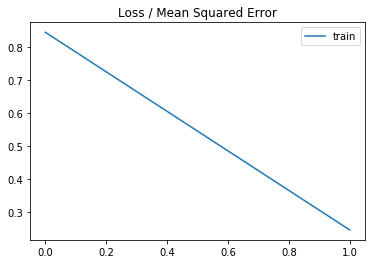

In [67]:
#Testing the model on it's loss.
from matplotlib import pyplot
train_mse = model.evaluate(Xtrain, Ytrain, verbose=0)
test_mse = model.evaluate(Xtest, Ytest, verbose=0)
print(train_mse, test_mse)
# plot loss during training
pyplot.title('Loss / Mean Squared Error')
pyplot.plot(history.history['loss'], label='train')
# pyplot.plot(history.history['val_loss'], label='validate')
# pyplot.xlim(75,100)
pyplot.legend()
pyplot.show()

(511,)


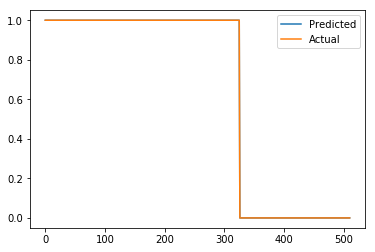

In [68]:
ypred = model.predict(Xtest)
ytest = np.argmax(Ytest,axis=1)
ypred = np.argmax(ypred,axis=1)
print(ypred.shape)
pyplot.plot(ypred,label='Predicted')
pyplot.plot(ytest,label='Actual')
# pyplot.xlim(600,800)
pyplot.legend()
pyplot.show()

In [69]:
ypred  = model.predict(freq_Vec)
# ypred = np.argmax(ypred,axis=1)
ypred

array([[9.9278235e-01, 7.2176317e-03],
       [5.9409861e-02, 9.4059014e-01],
       [9.7018290e-01, 2.9817035e-02],
       ...,
       [2.3148257e-02, 9.7685176e-01],
       [5.1348615e-03, 9.9486512e-01],
       [8.7605018e-05, 9.9991238e-01]], dtype=float32)

In [70]:
ytest = np.argmax(label,axis=1)
ytest.shape

(1989,)

In [71]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest,np.argmax(ypred,axis=1))

array([[ 924,    0],
       [   0, 1065]])

In [72]:
pol_score = []
for i in range(label.shape[0]):
  if label[i,0] == 1:
    pol_score.append(ypred[i,1]-ypred[i,0])
  else:
    pol_score.append(ypred[i,1]-ypred[i,0])

pol_score = np.array(pol_score).reshape(-1,1)
pol_score.shape

(1989, 1)

In [73]:
#Scaled polarity
from sklearn.preprocessing import StandardScaler
ss= StandardScaler()
pol_score_scaled = ss.fit_transform(pol_score)
pol_score_scaled

array([[-1.1038786 ],
       [ 0.84068507],
       [-1.0567955 ],
       ...,
       [ 0.9162316 ],
       [ 0.9537601 ],
       [ 0.9642754 ]], dtype=float32)

In [74]:
#Converting the data to a dataframe for further output process
out_df = pd.DataFrame(pol_score,columns=['Polarity Score(Unscaled)'])
out_df.insert(0,"Date",df['Date'])
out_df.insert(2,"Label",np.argmax(label,axis=1))
out_df.insert(1,"Polarity Score(Scaled)",pol_score_scaled)
out_df

,Date,Polarity Score(Scaled),Polarity Score(Unscaled),Label
0,2008-08-08,-1.103879,-0.985565,0
1,2008-08-11,0.840685,0.881180,1
2,2008-08-12,-1.056795,-0.940366,0
3,2008-08-13,-1.087153,-0.969508,0
4,2008-08-14,0.920434,0.957738,1
5,2008-08-15,0.810124,0.851842,1
6,2008-08-18,-0.975811,-0.862622,0
7,2008-08-19,-1.064758,-0.948010,0
8,2008-08-20,0.864146,0.903702,1
9,2008-08-21,0.846382,0.886649,1


In [0]:
#save the output to a csv file
out_df.to_csv("Polarity Score.csv")

In [0]:
import matplotlib.pyplot as plt

def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    '''
    Draw a neural network cartoon using matplotilb.
    
    :usage:
        >>> fig = plt.figure(figsize=(12, 12))
        >>> draw_neural_net(fig.gca(), .1, .9, .1, .9, [4, 7, 2])
    
    :parameters:
        - ax : matplotlib.axes.AxesSubplot
            The axes on which to plot the cartoon (get e.g. by plt.gca())
        - left : float
            The center of the leftmost node(s) will be placed here
        - right : float
            The center of the rightmost node(s) will be placed here
        - bottom : float
            The center of the bottommost node(s) will be placed here
        - top : float
            The center of the topmost node(s) will be placed here
        - layer_sizes : list of int
            List of layer sizes, including input and output dimensionality
    '''
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

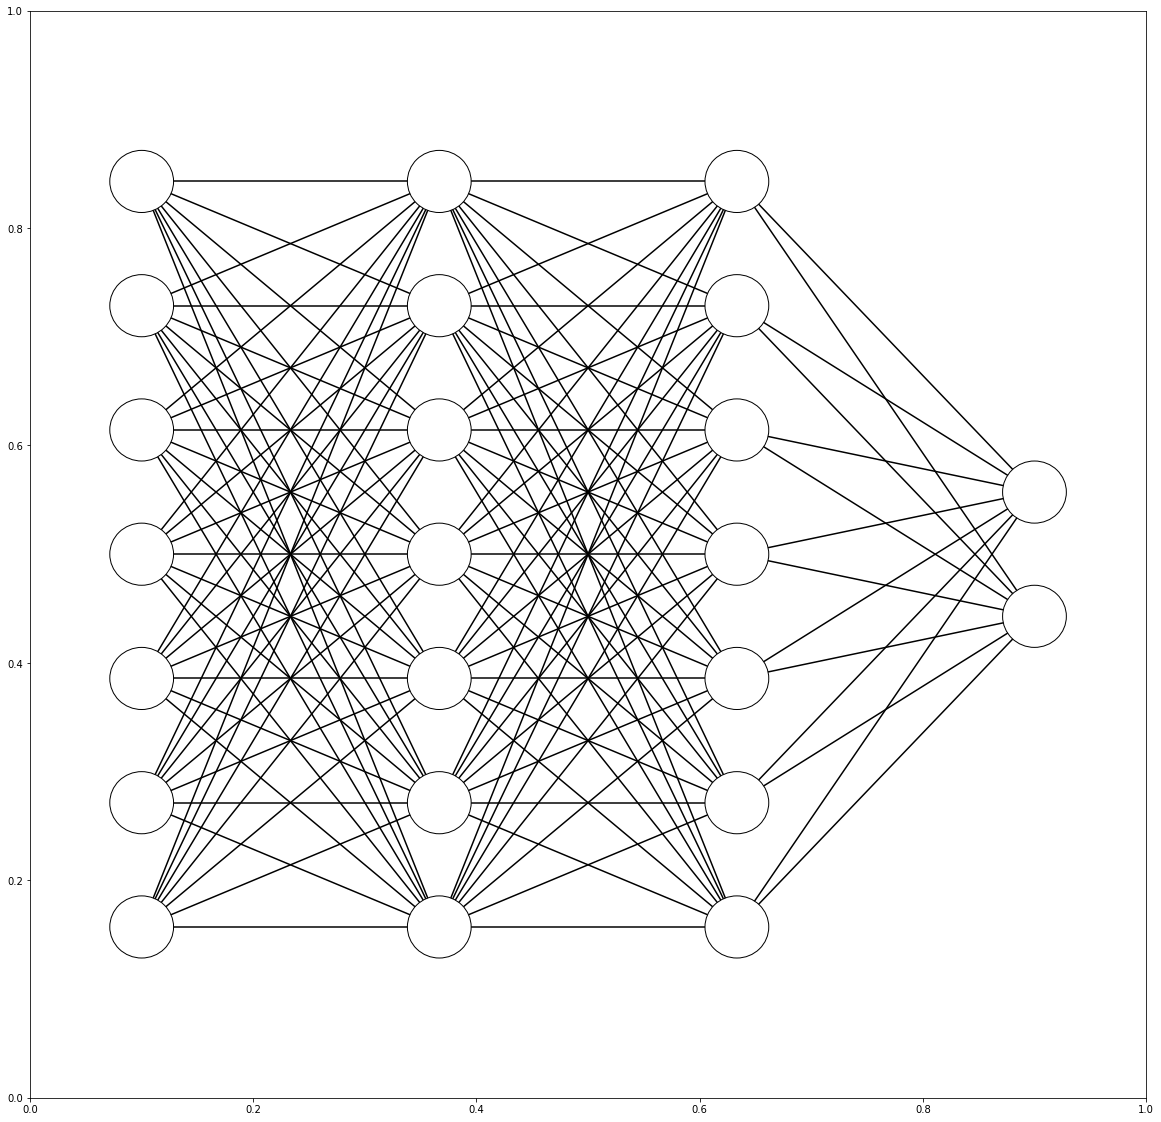

In [33]:
fig = plt.figure(figsize=(20, 20))
ax = fig.gca()
# ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [7,7,7, 2])
fig.savefig('nn.png')